In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

D 8.1.1 The trackdrive layout is a closed loop circuit built to the following guidelines:

* Straights: No longer than 80 m
* Constant Turns: up to 50 m diameter
* Hairpin Turns: Minimum of 9 m outside diameter (of the turn)
* Miscellaneous: Chicanes, multiple turns, decreasing radius turns, etc.
* The minimum track width is 3 m

D 8.1.2 The length of one lap is approximately 200 m to 500 m.

Handbook:
* Distance between cones is up to 5 m

### Let's load tracks from AMZ repository

In [2]:
path_to_track_files = "tracks"

In [3]:
track_files = os.listdir(path_to_track_files)

In [4]:
track_files

['handling_track.csv',
 'berlin_2018.csv',
 'modena_2019.csv',
 'rounded_rectangle.csv']

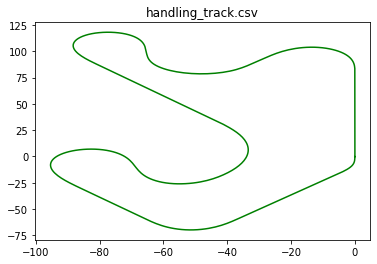

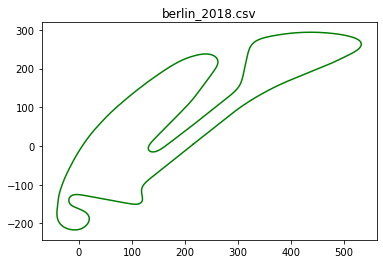

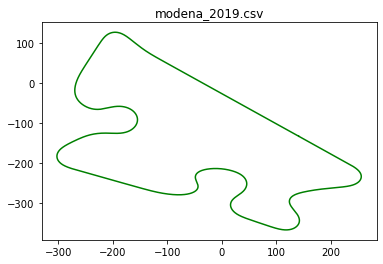

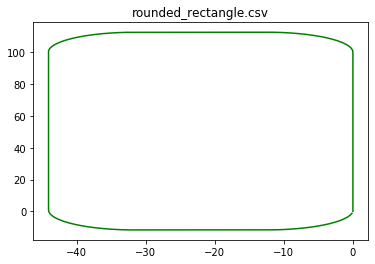

In [5]:
for file in track_files:
    track_points = pd.read_csv(os.path.join(path_to_track_files, file))
    X = [x for x in track_points["# x_m"]]
    Y = [y for y in track_points["y_m"]]
    plt.figure()
    plt.title(file)
    plt.plot(X, Y, "g")
    plt.show()

### Choose track to process

In [462]:
file = track_files[0]
file

'berlin_2018.csv'

In [463]:
track_points = pd.read_csv(os.path.join(path_to_track_files, file))

In [464]:
X = track_points["# x_m"].values
Y = track_points["y_m"].values
width_left = track_points["w_tr_left_m"].values
width_right = track_points["w_tr_right_m"].values

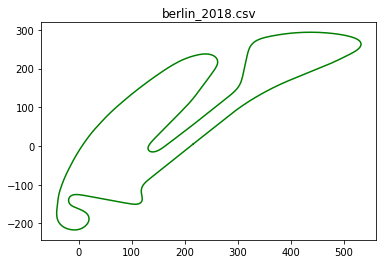

In [465]:
plt.figure()
plt.title(file)
plt.plot(X, Y, "g")
plt.show()

### Place track's center at (0, 0) coordinates

In [466]:
def center_track(X, Y):
    mean_X = (np.max(X) + np.min(X)) / 2
    mean_Y = (np.max(Y) + np.min(Y)) / 2
    X_centered = [x - mean_X for x in X]
    Y_centered = [y - mean_Y for y in Y]
    
    return X_centered, Y_centered

In [467]:
X, Y = center_track(X, Y)

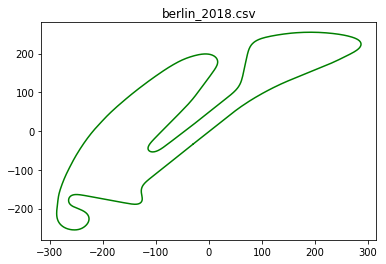

In [468]:
plt.figure()
plt.title(file)
plt.plot(X, Y, "g")
plt.show()

### Get cone positions

In [469]:
def get_cone_positions(track_X, track_Y):
    left_X, left_Y = [], [] # left border of track
    right_X, right_Y = [], []

    for i in range(len(track_X)):
        # Vector to cone is direction vector rotated on 90 degrees clockwise
        dir_vec = (track_X[i] - track_X[i-1], track_Y[i] - track_Y[i-1])
        cone_vec = (-dir_vec[1], dir_vec[0])
        cone_vec = [el / np.sqrt(cone_vec[0] ** 2 + cone_vec[1] **2) for el in cone_vec]# Normalize vector

        # Compute track borders
        left_point = (track_X[i-1] + cone_vec[0] * width_left[i-1], track_Y[i-1] + cone_vec[1] * width_left[i-1])
        right_point = (track_X[i-1] - cone_vec[0] * width_right[i-1], track_Y[i-1] - cone_vec[1] * width_right[i-1])

        left_X.append(left_point[0])
        left_Y.append(left_point[1])
        right_X.append(right_point[0])
        right_Y.append(right_point[1])
    return left_X, left_Y, right_X, right_Y

In [470]:
left_X, left_Y, right_X, right_Y = get_cone_positions(X, Y)

In [471]:
len(left_X), len(left_Y), len(right_X), len(right_Y), len(X), len(Y)

(2366, 2366, 2366, 2366, 2366, 2366)

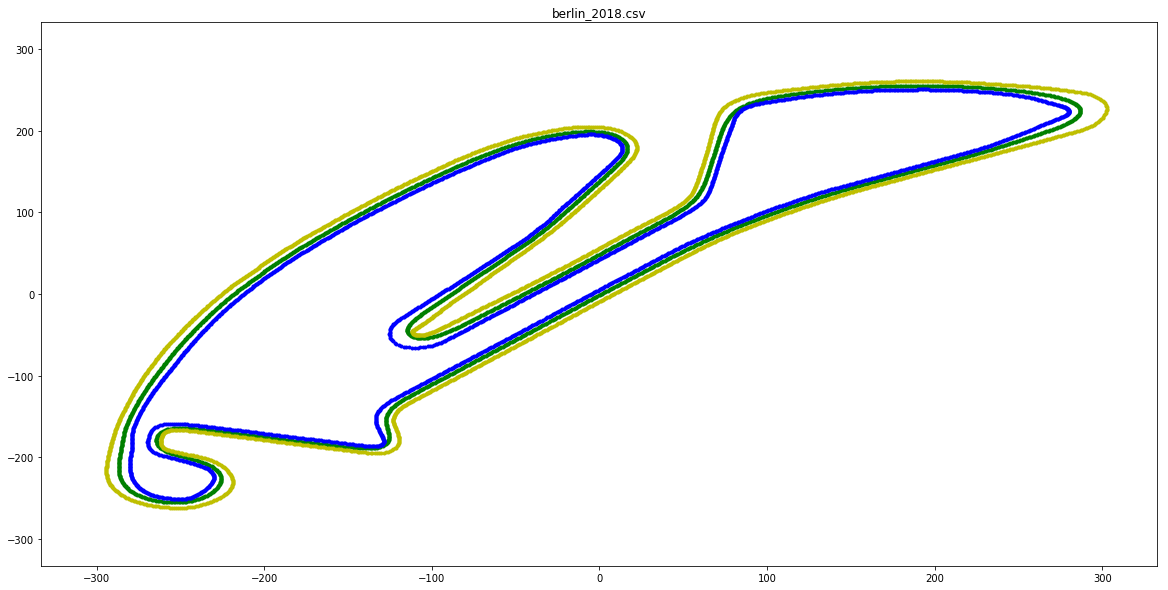

In [472]:
# start, end = 300, 500
start, end = 0, len(left_X) + 1

plt.figure(figsize=(20, 10))
plt.title(file)
max_coord = max([abs(coord) for coord in X + Y + left_X + left_Y + right_X + right_Y]) * 1.1
plt.xlim(-max_coord, max_coord)
plt.ylim(-max_coord, max_coord)
plt.plot(X[start:end], Y[start:end], "g.")
plt.plot(left_X[start:end], left_Y[start:end], "b.")
plt.plot(right_X[start:end], right_Y[start:end], "y.")
# plt.plot(X[0], Y[0], "g*")
# plt.plot(X[70], Y[70], "g*")
plt.show()

### Create 5m distance between cones

In [473]:
def filter_cones(X, Y, dist_between_cones):
    """Filter cones to have particular distance between them."""
    def l2_dist(point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    last_XY = (X[0], Y[0])
    X_distanced = [X[0]] # Take first point
    Y_distanced = [Y[0]]

    for i, (x, y) in enumerate(zip(X[1:], Y[1:])):
        if l2_dist(last_XY, [x, y]) > dist_between_cones:
            X_distanced.append(x)
            Y_distanced.append(y)
            last_XY = (x, y)
            
    return X_distanced, Y_distanced

In [474]:
dist_between_cones = 5 # m

left_X, left_Y = filter_cones(left_X, left_Y, dist_between_cones)
right_X, right_Y = filter_cones(right_X, right_Y, dist_between_cones)

In [475]:
len(left_X), len(left_Y), len(right_X), len(right_Y)

(416, 416, 443, 443)

### Save world

In [476]:
WORLD_FILENAME = "track/worlds/generated_track.wbt"

In [478]:
base_world_data_template = """#VRML_SIM R2020b utf8
WorldInfo {
  coordinateSystem "NUE"
}
Viewpoint {
  orientation 0.029278267973153974 0.9865351701450629 0.16090724375037946 3.4590949147245222
  position -133 60.3 -223
}
TexturedBackground {
}
TexturedBackgroundLight {
}
Floor {
  size {} {}
  appearance Asphalt {
  }
}
"""
cones_prefix = """Transform {
  scale 0.5 0.5 0.5
  children [
"""
cones_postfix = """  ]
}
"""
cone_template = """    TrafficCone {
      translation {} 0 {}
      name "{} cone({})"
      physics Physics {
      }
    }
"""

In [479]:
floor_size_X = max([abs(x) for x in X]) * 1.1 # To make track not be near border of floor
floor_size_Y = max([abs(y) for y in Y]) * 1.1
floor_size_X, floor_size_Y

(315.5850500000001, 280.841)

In [480]:
base_world_data = base_world_data_template.replace("{}", str(floor_size_X), 1).replace("{}", str(floor_size_Y), 1)

In [279]:
# blue_cones = [cone_template.replace("{}", str(x), 1).replace("{}", str(y), 1).replace("{}", "Blue", 1).replace("{}", str(i), 1)
#              for i, (x, y) in enumerate(zip(X, Y))]

In [482]:
cones = []

for cone_color, X, Y in [("Blue", left_X, left_Y), ("Yellow", right_X, right_Y)]:
    cones.extend([cone_template.replace("{}", str(x), 1).replace("{}", str(y), 1)\
                               .replace("{}", cone_color, 1).replace("{}", str(i), 1)
                 for i, (x, y) in enumerate(zip(X, Y))])

In [484]:
len(cones), len(left_X), len(left_Y), len(right_X), len(right_Y)

(859, 416, 416, 443, 443)

In [485]:
with open(WORLD_FILENAME, "w") as f:
    f.write(base_world_data)
    f.write(cones_prefix)
    for cone in cones:
        f.write(cone)
    f.write(cones_postfix)

#### Save cone positions TODO need to take into account scale of cones' transformation in Webots

In [498]:
# Blue cones on left, Yellow on right (Handbook). In Webots "y" axis goes up, so we use "z" axis instead
data = {"color": ["blue"] * len(left_X) + ["yellow"] * len(right_X),
        "x": left_X + right_X,
        "z": left_Y + right_Y}

In [499]:
cones_coordinates = pd.DataFrame(data)

In [516]:
cones_coordinates.to_csv("cone_coordinates.csv")
# cones_coordinates.to_csv("track/controllers/lidar_controller/cone_coordinates.csv")

# Circle track generation

In [253]:
# Hard coded cooridnates
with open("circle_track_cones.wbt") as f:
    lines = f.readlines()

In [254]:
translations = [line.strip().split(" ") for line in lines if "translation" in line]
translations = [(float(line[1]), float(line[3])) for line in translations]

In [255]:
circle_track_cone_scale = 0.06

In [256]:
# Hard coded colors
circle_track_colors = [
    "Y","Y","B","B","Y","B","B","B","Y","B","Y","B","Y","Y","B","B","B","Y","B","B","B","Y",
    "Y","Y","Y","B","B","B","B","B","B","B","Y","Y","Y","B","B","B","B","Y","B",
]

In [257]:
assert len(color) == len(translations)

In [258]:
translations_X, translations_Z = list(zip(*translations))

In [259]:
# Cone full data
circle_track_cones_data = [("blue" if color == "B" else "yellow", X * circle_track_cone_scale, Z * circle_track_cone_scale) 
                           for color, X, Z in zip(circle_track_colors, translations_X, translations_Z)]

In [260]:
############################## FOR DEBUG

# circle_track_cones_data = circle_track_cones_data[:10]

#########################################################################################

In [261]:
circle_track_colors, circle_track_X, circle_track_Z = list(zip(*circle_track_cones_data))

In [262]:
# circle_track_data = {"color": ["blue" if color == "B" else "yellow" for color in circle_track_colors],
#                      "x": [circle_track_cone_scale * x for x in translations_X],
#                      "z": [circle_track_cone_scale * z for z in translations_Z]}

In [263]:
circle_track_data = {"color": circle_track_colors, "x": circle_track_X, "z": circle_track_Z}

In [264]:
circle_track_cones_coordinates = pd.DataFrame(circle_track_data)

In [265]:
circle_track_cones_coordinates.to_csv("Webots environment/controllers/circle_track_controller/circle_track_cones_coordinates.csv", index=False)

### Save world

In [266]:
WORLD_FILENAME_CIRCLE_TRACK = "Webots environment/worlds/generated_circle_track.wbt"

In [267]:
base_world_data_template = """#VRML_SIM R2020b utf8
WorldInfo {
  basicTimeStep 128
  coordinateSystem "NUE"
}
Viewpoint {
  orientation -0.0037899260444160298 0.9052768790153575 0.42480514213082626 3.1254400344974997
  position -0.010099015509915321 0.9455115057217769 -0.772250962099575
}
TexturedBackground {
}
TexturedBackgroundLight {
}
RectangleArena {
  floorSize 10 10
}
DEF ROBOT Robot {
  translation 0.117707 0.04 -0.286743
  children [
      Accelerometer {
      translation 0 0.06 0
      children [
        Shape {
          appearance PBRAppearance {
            baseColor 0.333333 1 1
            metalness 0
          }
          geometry DEF ACCELEROMETER Box {
            size 0.01 0.01 0.01
          }
        }
      ]
      boundingObject USE ACCELEROMETER
    }
    InertialUnit {
      translation 0 0.03 0
      rotation 0 1 0 -1.57
      children [
        Shape {
          appearance PBRAppearance {
            baseColor 1 1 0
            metalness 0
          }
          geometry DEF IMU Box {
            size 0.01 0.01 0.01
          }
        }
      ]
      name "imu"
    }
    Gyro {
      translation 0 0.05 0
      children [
        Shape {
          appearance PBRAppearance {
            baseColor 0.333333 1 0
            metalness 0
          }
          geometry DEF GYRO Box {
            size 0.01 0.01 0.01
          }
        }
      ]
      boundingObject USE GYRO
    }
    GPS {
      translation 0 0.04 0
      children [
        Shape {
          appearance PBRAppearance {
            baseColor 0.333333 0 1
            metalness 0
          }
          geometry DEF GPS Box {
            size 0.01 0.01 0.01
          }
        }
      ]
      boundingObject USE GPS
    }
    Lidar {
      translation 0 0.03 0.09
      rotation 0 1 0 3.141592653589793
      children [
        Shape {
          appearance PBRAppearance {
            baseColor 0 0 1
            metalness 0
          }
          geometry DEF LIDAR Box {
            size 0.01 0.01 0.01
          }
        }
      ]
      tiltAngle -0.12
      fieldOfView 1.57
      numberOfLayers 10
      maxRange 4
    }
    DEF BODY Shape {
      appearance PBRAppearance {
        baseColor 1 0 0
        metalness 0
      }
      geometry Box {
        size 0.1 0.05 0.2
      }
    }
    HingeJoint {
      jointParameters HingeJointParameters {
        anchor 0.06 0 0.05
      }
      device [
        RotationalMotor {
          name "wheel1"
        }
      ]
      endPoint DEF WHEEL1 Solid {
        translation 0.06005186559358913 -3.157723486129075e-05 0.0500207526884499
        rotation 0.011355480419242383 -0.014724716484270891 -0.9998271029477577 4.708723537184392
        children [
          DEF WHEEL Shape {
            appearance PBRAppearance {
              baseColor 0 1 0
              metalness 0
            }
            geometry Cylinder {
              height 0.02
              radius 0.04
            }
          }
        ]
        boundingObject USE WHEEL
        physics DEF WHEEL_PH Physics {
        }
      }
    }
    HingeJoint {
      jointParameters HingeJointParameters {
        anchor -0.06 0 0.05
      }
      device [
        RotationalMotor {
          name "wheel2"
        }
      ]
      endPoint DEF WHEEL2 Solid {
        translation -0.06000627491628889 -1.1261465698166471e-05 0.05001037499794944
        rotation 0.006888329611843957 -0.006479269089461786 -0.9999552839938518 4.7078475462419815
        children [
          USE WHEEL
        ]
        name "solid(1)"
        boundingObject USE WHEEL
        physics USE WHEEL_PH
      }
    }
    HingeJoint {
      jointParameters HingeJointParameters {
        anchor 0.06 0 -0.05
      }
      device [
        RotationalMotor {
          name "wheel3"
        }
      ]
      endPoint DEF WHEEL3 Solid {
        translation 0.06000581021086107 2.7169818866217477e-06 -0.04998451417276848
        rotation 0.011355081800713616 -0.01472505624181835 -0.9998271024712094 4.708722744097527
        children [
          USE WHEEL
        ]
        name "solid(2)"
        boundingObject USE WHEEL
        physics USE WHEEL_PH
      }
    }
    HingeJoint {
      jointParameters HingeJointParameters {
        anchor -0.06 0 -0.05
      }
      device [
        RotationalMotor {
          name "wheel4"
        }
      ]
      endPoint DEF WHEEL4 Solid {
        translation -0.060051451242279466 1.2015803057747292e-05 -0.04996466295142506
        rotation 0.006888333402824968 -0.006479218054907053 -0.9999552842984172 4.707846319313928
        children [
          USE WHEEL
        ]
        name "solid(3)"
        boundingObject USE WHEEL
        physics USE WHEEL_PH
      }
    }
  ]
  boundingObject USE BODY
  physics Physics {
  }
  controller "circle_track_controller"
  controllerArgs [
    ""
  ]
  supervisor TRUE
}
"""
cones_prefix = """DEF CONES Transform {
  scale 0.06 0.06 0.06
  children [
"""
cones_postfix = """  ]
}
"""
cone_template = """    TrafficCone {
      translation {} 0 {}
      name "{} cone({})"
      physics Physics {
      }
    }
"""

In [268]:
floor_size_X = max([abs(x) for x in translations_X]) * 1.1 # To make track not be near border of floor
floor_size_Y = max([abs(y) for y in translations_Z]) * 1.1
floor_size_X, floor_size_Y

(32.97965000000001, 24.182620000000004)

In [269]:
base_world_data = base_world_data_template.replace("{}", str(floor_size_X), 1).replace("{}", str(floor_size_Y), 1)

In [270]:
circle_track_cones = [cone_template.replace("{}", str(x / circle_track_cone_scale), 1).replace("{}", str(y / circle_track_cone_scale), 1)\
                                    .replace("{}", cone_color, 1).replace("{}", str(i), 1) 
                      for i, (cone_color, x, y) in enumerate(circle_track_cones_data)]

In [271]:
len(circle_track_cones), len(circle_track_cones_data)

(41, 41)

In [272]:
with open(WORLD_FILENAME_CIRCLE_TRACK, "w") as f:
    f.write(base_world_data)
    f.write(cones_prefix)
    for cone in circle_track_cones:
        f.write(cone)
    f.write(cones_postfix)